# MPB ModeSolver

Now let's obtain the plot on the right (Figure from [3]) :

![alt text](http://www.simpetus.com/files/SOI_waveguide_bands.png)

In [1]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

Start by defining the geometry from last time :

In [2]:
# Parameters for the waveguide
w = 0.50  # Si width (um)
h = 0.22  # Si height (um)

# Materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

sc_y = 2  # supercell width (um)
sc_z = 2  # supercell height (um)
resolution = 32  # pixels/um
geometry_lattice = mp.Lattice(size=mp.Vector3(0, sc_y, sc_z))

# define the 2d blocks for the strip and substrate
geometry = [mp.Block(size=mp.Vector3(mp.inf, w, h),
                     center=mp.Vector3(), material=Si),
            mp.Block(size=mp.Vector3(mp.inf, mp.inf, 0.5*(sc_z-h)),
                     center=mp.Vector3(z=0.25*(sc_z+h)), material=SiO2)]

### Defining the simulation

Now, instead of only initializing the geometry, we will load simulation parameters.

In [3]:
# The k (i.e. beta, i.e. propagation constant) points to look at, in
# units of 2*pi/um.  We'll look at num_k points from k_min to k_max.
num_k = 20
k_min = 0.1
k_max = 2.0
k_points = mp.interpolate(num_k, [mp.Vector3(k_min), mp.Vector3(k_max)])

# Increase this to see more modes.  (The guided ones are the ones below the
# light line, i.e. those with frequencies < kmag / 1.45, where kmag
# is the corresponding column in the output if you grep for "freqs:".)
num_bands = 4

In [4]:
# ModeSolver object
ms = mpb.ModeSolver(
    geometry_lattice=geometry_lattice,
    geometry=geometry,
    # Add new things pertaining to simulation
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands,
    )

Now run the simulation. There are many options for what to solve for and what to report, see https://mpb.readthedocs.io/en/latest/Python_User_Interface/#run-functions.

In [5]:
ms.run()

Initializing eigensolver data
Computing 4 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 1 x 64 x 64.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 2, 0)
     (0, 0, 2)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 0.5)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,0.5,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0.555)
          size (1e+20,1e+20,0.89)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
22 k-points
  Vector3<0.1, 0.0, 0.0>
  Vector3<0.19047619047619047, 0.0, 0.0>
  Vector3<0.28095238095238095, 0.0, 0.0>
  Vector3<0.37142857142857144, 0.0, 0.0>
  Vector3<0.46190476190476193, 0.0, 0.0>
  Vect

It solved, great! We can see from the text output lines like :

`solve_kpoint (0.1,0,0):
Solving for bands 1 to 4...
Finished solving for bands 1 to 4 after 28 iterations.
freqs:, 1, 0.1, 0, 0, 0.1, 0.0807582, 0.0855765, 0.3147, 0.394675
elapsed time for k point: 0.14001059532165527`

This contains our band information. Unfortunately, MPB only keeps in memory one at a time. So we only have access to the last one :

In [6]:
print(ms.current_k)
print(ms.freqs)

Vector3<2.0, 0.0, 0.0>
[0.7631671678430061, 0.8666725405654846, 0.9248390743934869, 0.9638311239052703]


So let's do it again, this time capturing the output :

In [6]:
%%capture --no-stderr output
ms.run()

In [7]:
output_text = output.stdout
output_text.split('\n')

['Initializing eigensolver data',
 'Computing 4 bands with 1e-07 tolerance',
 'Working in 3 dimensions.',
 'Grid size is 1 x 64 x 64.',
 'Solving for 4 bands at a time.',
 'Creating Maxwell data...',
 'Mesh size is 3.',
 'Lattice vectors:',
 '     (1, 0, 0)',
 '     (0, 2, 0)',
 '     (0, 0, 2)',
 'Cell volume = 4',
 'Reciprocal lattice vectors (/ 2 pi):',
 '     (1, -0, 0)',
 '     (-0, 0.5, -0)',
 '     (0, -0, 0.5)',
 'Geometric objects:',
 '     block, center = (0,0,0)',
 '          size (1e+20,0.5,0.22)',
 '          axes (1,0,0), (0,1,0), (0,0,1)',
 '     block, center = (0,0,0.555)',
 '          size (1e+20,1e+20,0.89)',
 '          axes (1,0,0), (0,1,0), (0,0,1)',
 'Geometric object tree has depth 2 and 8 object nodes (vs. 2 actual objects)',
 'Initializing epsilon function...',
 'Solving for band polarization: .',
 'Initializing fields to random numbers...',
 '22 k-points',
 '  Vector3<0.1, 0.0, 0.0>',
 '  Vector3<0.19047619047619047, 0.0, 0.0>',
 '  Vector3<0.2809523809523809

### Analyzing the results

Let's parse every line that begins with 'freqs :' in the output.

Notice the lines all have the same syntax `'freqs:, 22, 2, 0, 0, 2, 0.846477, 0.874081, 1.04852, 1.16543',`

i.e. for all the lines that start by 'freqs:' contains all the information we need in the form `freqs:, k index, kx, ky, kz, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8 ...`. Python's `split` function and treating strings as arrays (slicing and indexing) is handy :

In [8]:
freqs = []
ks = []
line_header = "freqs:"
for ln in output_text.split('\n'):
    if ln.startswith(line_header):
        print(ln)
        line = ln.split(', ')
        print(line)
        ks.append([line[2], line[3], line[4]])
        freqs.append([line[-4], line[-3], line[-2], line[-1]])
        
freqs = np.array(freqs, dtype=np.float32)
ks = np.array(ks, dtype=np.float32)

freqs:, 1, 0.1, 0, 0, 0.1, 0.0794202, 0.0849623, 0.297663, 0.37481
['freqs:', '1', '0.1', '0', '0', '0.1', '0.0794202', '0.0849623', '0.297663', '0.37481']
freqs:, 2, 0.190476, 0, 0, 0.190476, 0.150218, 0.160326, 0.324018, 0.383469
['freqs:', '2', '0.190476', '0', '0', '0.190476', '0.150218', '0.160326', '0.324018', '0.383469']
freqs:, 3, 0.280952, 0, 0, 0.280952, 0.219035, 0.232794, 0.36303, 0.398284
['freqs:', '3', '0.280952', '0', '0', '0.280952', '0.219035', '0.232794', '0.36303', '0.398284']
freqs:, 4, 0.371429, 0, 0, 0.371429, 0.284828, 0.301118, 0.410931, 0.417364
['freqs:', '4', '0.371429', '0', '0', '0.371429', '0.284828', '0.301118', '0.410931', '0.417364']
freqs:, 5, 0.461905, 0, 0, 0.461905, 0.34589, 0.36477, 0.440364, 0.463544
['freqs:', '5', '0.461905', '0', '0', '0.461905', '0.34589', '0.36477', '0.440364', '0.463544']
freqs:, 6, 0.552381, 0, 0, 0.552381, 0.398211, 0.424058, 0.470557, 0.516771
['freqs:', '6', '0.552381', '0', '0', '0.552381', '0.398211', '0.424058', '0.4

In [9]:
print(freqs)
print(ks)

[[0.0794202 0.0849623 0.297663  0.37481  ]
 [0.150218  0.160326  0.324018  0.383469 ]
 [0.219035  0.232794  0.36303   0.398284 ]
 [0.284828  0.301118  0.410931  0.417364 ]
 [0.34589   0.36477   0.440364  0.463544 ]
 [0.398211  0.424058  0.470557  0.516771 ]
 [0.436446  0.479309  0.513457  0.567861 ]
 [0.463503  0.529944  0.566628  0.615651 ]
 [0.485926  0.574409  0.623957  0.66078  ]
 [0.506776  0.611532  0.682582  0.698461 ]
 [0.527159  0.642054  0.725485  0.740367 ]
 [0.547509  0.667911  0.747291  0.775545 ]
 [0.568008  0.690839  0.766489  0.796961 ]
 [0.588733  0.711999  0.784403  0.816743 ]
 [0.609713  0.732111  0.80173   0.835754 ]
 [0.630952  0.751623  0.818853  0.854324 ]
 [0.652443  0.770818  0.83599   0.872643 ]
 [0.674172  0.78988   0.853267  0.890837 ]
 [0.696125  0.808928  0.870757  0.908996 ]
 [0.718285  0.828044  0.888503  0.927185 ]
 [0.740637  0.847281  0.906527  0.945451 ]
 [0.763167  0.866673  0.924839  0.963831 ]]
[[0.1      0.       0.      ]
 [0.190476 0.       0. 

We can now plot. Let's add the lightline too :

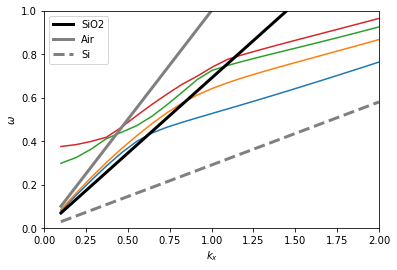

In [12]:
fig, ax = plt.subplots()

ax.plot(ks[:,0], freqs)
ax.plot(ks[:,0], ks[:,0]/1.45, 'k-', linewidth=3, label='SiO2')
ax.plot(ks[:,0], ks[:,0]/1, '-', color='gray', linewidth=3, label='Air')
ax.plot(ks[:,0], ks[:,0]/3.45, '--', color='gray', linewidth=3, label='Si')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$\omega$')
ax.set_xlim([0,2])
ax.set_ylim([0,1])
ax.legend()

### Addendum : saving/loading files from Python

Google is your friend!

In [12]:
# Saving text files
string = 'test' # could be straight up output.stdout
text_file = open("output.txt", "w")
text_file.write(string)
text_file.close()

# Loading text files
text_file = open("output.txt", "r")
print(text_file.readline())

test


In [13]:
# Saving numpy arrays
array = freqs
np.save('array.npy', array)

# Loading numpy arrays
array_from_file = np.load('array.npy')
print(array_from_file)

# Saving general objects : pickle, dill, etc.

# MEEP/MPB likes the h5 format; there is also a package for that (see next notebook)
# http://docs.h5py.org/en/stable/quick.html

[[0.0794202 0.0849623 0.297663  0.37481  ]
 [0.150218  0.160326  0.324018  0.383469 ]
 [0.219035  0.232794  0.36303   0.398284 ]
 [0.284828  0.301118  0.410931  0.417364 ]
 [0.34589   0.36477   0.440364  0.463544 ]
 [0.398211  0.424058  0.470557  0.516771 ]
 [0.436446  0.479309  0.513457  0.567861 ]
 [0.463503  0.529944  0.566628  0.615651 ]
 [0.485926  0.574409  0.623957  0.66078  ]
 [0.506776  0.611532  0.682582  0.698461 ]
 [0.527159  0.642054  0.725485  0.740367 ]
 [0.547509  0.667911  0.747291  0.775545 ]
 [0.568008  0.690839  0.766489  0.796961 ]
 [0.588733  0.711999  0.784403  0.816743 ]
 [0.609713  0.732111  0.80173   0.835754 ]
 [0.630952  0.751623  0.818853  0.854324 ]
 [0.652443  0.770818  0.83599   0.872643 ]
 [0.674172  0.78988   0.853267  0.890837 ]
 [0.696125  0.808928  0.870757  0.908996 ]
 [0.718285  0.828044  0.888503  0.927185 ]
 [0.740637  0.847281  0.906527  0.945451 ]
 [0.763167  0.866673  0.924839  0.963831 ]]


# Waveguide parameters

There is an inverse-solver that can return the wavevector at a specified frequency (see https://mpb.readthedocs.io/en/latest/Python_User_Interface/#the-inverse-problem-k-as-a-function-of-frequency). It needs a few parameters, since it is an iterative solver :

In [14]:
%%capture

f_mode = 1/1.55   # frequency corresponding to 1.55 um                                                                                                             
band_min = 1
band_max = 1 # Look at the lowest mode
kdir = mp.Vector3(1)
tol = 1e-6
kmag_guess = f_mode*3.45
kmag_min = f_mode*0.1
kmag_max = f_mode*4.0

k_fmode = ms.find_k(mp.NO_PARITY, f_mode, band_min, band_max, kdir, tol, kmag_guess,
          kmag_min, kmag_max, mpb.output_poynting_x)

The dispersion relation yields the effective index :

$$ n_{eff} = \frac{c}{v_{phase}} = \frac{c}{\omega/k} = \frac{ck}{\omega} $$

In [15]:
k_fmode[0] / f_mode

2.3514721959617

This is valid at this wavelength. For higher-order derivatives (group velocity, dispersion parameter, etc.), MPB will NOT give physically accurate results by default as commercial solvers because it does not include material dispersion. This can be accounted for, however, see https://github.com/abulnaga1/MPB_Simulations#material_dispersion.